# Suboptimal atlas analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [6]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

In [7]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/atlas_subsampling/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6], 'closest_ACR':pal[2], 'random_ACR':pal[8]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
%%R -i figdir -i design_palette_df
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [11]:

short_pop_names = {
    "DC":'conventional_dendritic_cell', 
    "naive B":'naive_B_cell',
    "memory B":'memory_B_cell',
    "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell', 
    'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
     "neutrophil":'neutrophil',
#     "cDC":'conventional_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte'}

short_pop_names={v:k for k,v in short_pop_names.items()}

Get size of OOR populations

In [434]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

## Get OOR state population size
oor_state_size = {}
for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_perturb')]:
        if 'neutrophil' not in d:
            acr_adata = sc.read_h5ad(outdir + d +'/acr_design.h5ad', backed=True)
            ct = acr_adata.obs[acr_adata.obs['OOR_state']==1]['cell_type'].unique()[0]
            oor_state_size[ct] = acr_adata.obs['OOR_state'].sum()

oor_state_frac = {k:v/(500*(14+16)) for k,v in oor_state_size.items()}
oor_state_frac

oor_state_size

{'memory_B_cell': 398,
 'conventional_dendritic_cell': 108,
 'naive_B_cell': 601,
 'central_memory_CD4_positive_alpha_beta_T_cell': 1811,
 'plasmablast': 15,
 'platelet': 123,
 'plasmacytoid_dendritic_cell': 43,
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell': 779,
 'classical_monocyte': 391,
 'erythrocyte': 10,
 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell': 396,
 'natural_killer_cell': 1067,
 'effector_memory_CD8_positive_alpha_beta_T_cell': 1436,
 'mucosal_invariant_T_cell': 203,
 'CD14_low_CD16_positive_monocyte': 124}

## Load full healthy PBMC dataset

In [12]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'
query_batch = '10_1038_s41591_021_01329_2'

In [113]:
adata = sc.read_h5ad(outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad', backed=True)

Save dataset IDs

In [24]:
dataset_id_ls = adata.obs[batch_obs].unique().tolist()
dataset_id_ls.remove(query_batch)

with open(outdir + 'atlas_dataset_IDs.txt', 'w') as f:
    f.writelines('\n'.join(dataset_id_ls))

Save celltype counts

In [566]:
## Count number of cells per celltype and dataset
ct_size = adata.obs.groupby(['dataset_id', 'cell_type']).size().reset_index()
ct_size.columns = ['dataset_id', 'cell_type', 'n_cells']
ct_size = ct_size[ct_size.n_cells > 0]

## Count number of cells per celltype and dataset
donor_size = adata.obs.drop_duplicates(['dataset_id', 'donor_id']).groupby('dataset_id').size().reset_index()
donor_size.columns = ['dataset_id', 'n_donors']
# ct_size = ct_size[ct_size.n_cells > 0]
ct_size = pd.merge(ct_size, donor_size)

In [567]:
ct_size.to_csv(outdir + 'atlas_datasets_ncells_ct.csv')

In [117]:
%%R -i ct_size
dim(ct_size)

[1] 186   3


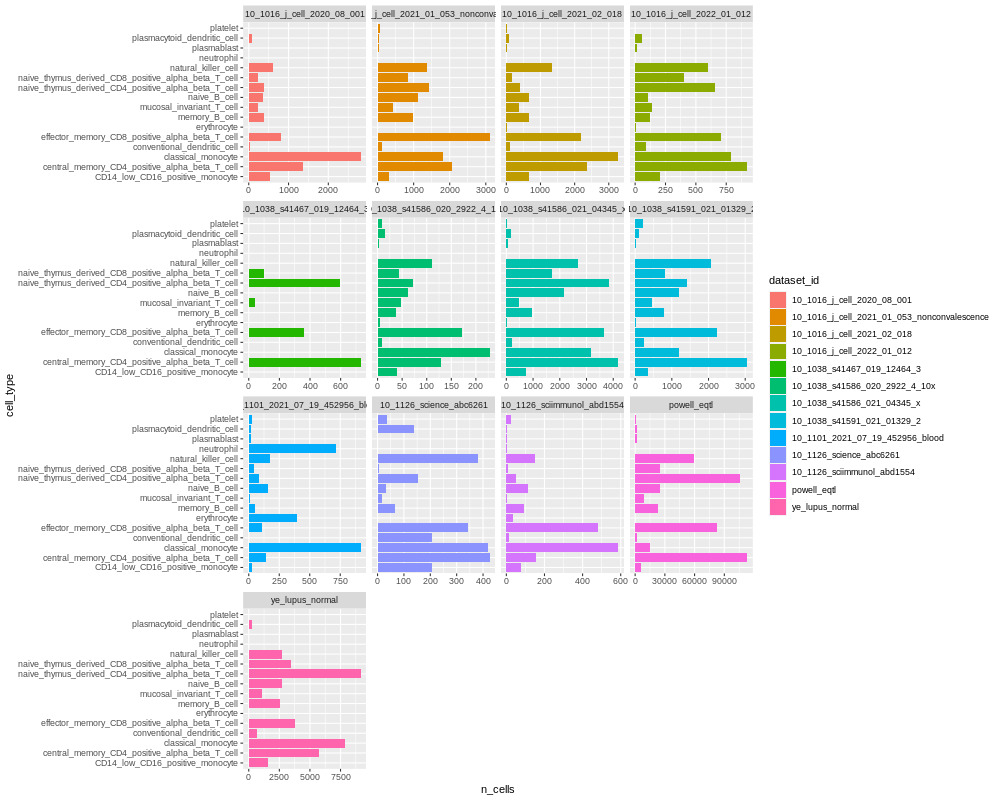

In [118]:
%%R -w 1000 -h 800
ct_size %>%
    ggplot(aes(cell_type, n_cells, fill=dataset_id)) +
    geom_col() +
    facet_wrap(dataset_id~., scales='free_x') +
    coord_flip()

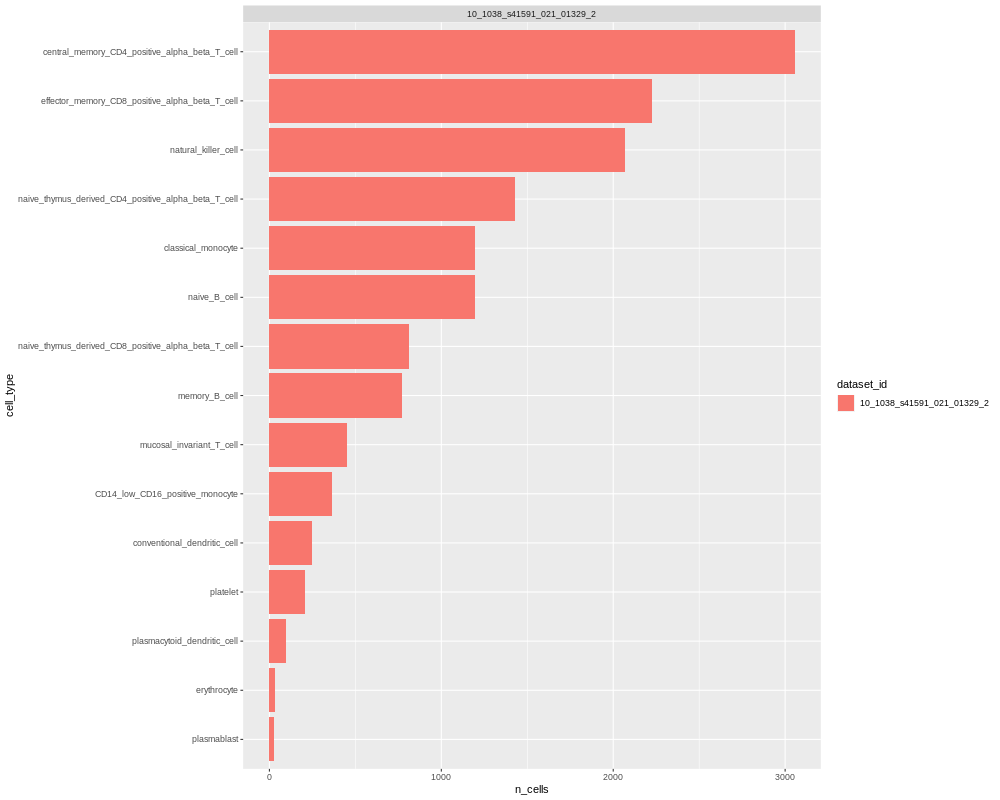

In [92]:
%%R -w 1000 -h 800
ct_size %>%
    filter(dataset_id == '10_1038_s41591_021_01329_2') %>%
    group_by(cell_type) %>%
    mutate(mean_n_cells = mean(n_cells)) %>%
    ungroup() %>%
    arrange(mean_n_cells) %>%
    mutate(cell_type = factor(cell_type, levels=unique(cell_type))) %>%
    ggplot(aes(cell_type, n_cells, fill=dataset_id)) +
    geom_col() +
    facet_wrap(dataset_id~., scales='free_x') +
    coord_flip()

In [131]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
annotation_col = 'cell_type'
batch_col = 'dataset_id'
query_dataset = '10_1038_s41591_021_01329_2'
split_seed = 2022
keep_n_studies = 10

import argparse
from multiprocessing.sharedctypes import Value
import os
import numpy as np
import scanpy as sc

from oor_benchmark.api import check_dataset
from oor_benchmark.datasets.simulation import simulate_query_reference
from oor_benchmark.methods import scArches_milo
from milopy.utils import write_milo_adata

def clean_pop_name(string):
    return(''.join(e if e.isalnum() else '_' for e in string))

adata = sc.read_h5ad(outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad')

# Select ctrl and disease samples
np.random.seed(split_seed)
query_samples = adata.obs['sample_id'][adata.obs['dataset_id']
                                       == query_dataset].unique()
samples_design = np.random.choice((0, 1), len(query_samples))
ctrl_samples = query_samples[samples_design == 1]
query_samples = query_samples[samples_design == 0]

adata.obs['dataset_group'] = 'atlas'
adata.obs.loc[adata.obs.sample_id.isin(ctrl_samples),'dataset_group'] = 'ctrl'
adata.obs.loc[adata.obs.sample_id.isin(query_samples),'dataset_group'] = 'query'

## Count number of cells per celltype and dataset in atlas
atlas_adata = adata[adata.obs['dataset_group'] == 'atlas']
ct_size = atlas_adata.obs.groupby(['dataset_id', 'cell_type']).size().reset_index()
ct_size.columns = ['dataset_id', 'cell_type', 'n_cells']
ct_size = ct_size[ct_size.n_cells > 0]

## Sort study IDs by abundance of cell type of interest
ct_oi = ['conventional_dendritic_cell']
mean_n_cells_ct = ct_size[ct_size.cell_type.isin(ct_oi)].groupby('dataset_id').mean('n_cells').fillna(0).sort_values('n_cells', ascending=False)
order_datasets_exclude = mean_n_cells_ct.index.tolist()

## Exclude studies where CT oi is most abundant
exclude_studies = order_datasets_exclude[:len(order_datasets_exclude) - keep_n_studies]
adata = adata[~adata.obs['dataset_id'].isin(exclude_studies)].copy()
assert adata.obs['dataset_id'].nunique() == keep_n_studies + 1
assert adata.obs[adata.obs['dataset_group'] == 'atlas']['dataset_id'].nunique() == keep_n_studies
assert adata.obs[adata.obs['dataset_group'] != 'atlas']['dataset_id'].unique() == query_dataset

In [94]:
obs_df = adata.obs.copy()

In [95]:
n_cells_ls = []
n_samples_ls = []
n_cells_ct_ls = []
keep_datasets = order_datasets_exclude.copy()
for d in order_datasets_exclude:
    n_samples = obs_df[obs_df.dataset_id.isin(keep_datasets)]['sample_id'].nunique()
    n_cells = obs_df[obs_df.dataset_id.isin(keep_datasets)]['sample_id'].shape[0]
    n_cells_ct = obs_df[(obs_df.dataset_id.isin(keep_datasets)) & (obs_df.cell_type.isin(ct_oi))]['sample_id'].shape[0]
    n_samples_ls.append(n_samples)
    n_cells_ls.append(n_cells)
    n_cells_ct_ls.append(n_cells_ct)
    keep_datasets.remove(d)

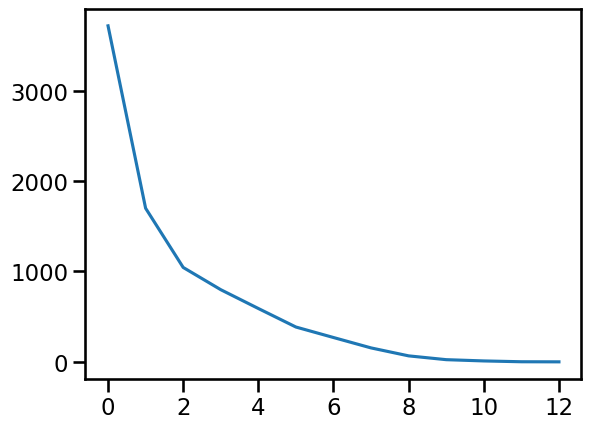

In [100]:
plt.plot(n_cells_ct_ls)

### Parse results

In [5]:
from oor_benchmark.metrics import FDR_TPR_FPR
from oor_benchmark.metrics import auprc

def harmonize_output(adata, signif_alpha=0.1):
    if adata.isbacked:
        sample_adata = adata.uns['nhood_adata'].to_memory().T
    else:
        sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()


def parse_design(adata, ct, ref_design):
    harmonize_output(adata)
    tpr_df = FDR_TPR_FPR.FDR_TPR_FPR(adata)
    auprc_df = auprc.auprc(adata, return_curve=True)
    nhoods_df = adata.uns['sample_adata'].var.copy()
    tpr_df['design'] = ref_design
    tpr_df['OOR_state_name'] = ct
    auprc_df['design'] = ref_design
    auprc_df['OOR_state_name'] = ct
    nhoods_df['design'] = ref_design
    nhoods_df['OOR_state_name'] = ct
    return(nhoods_df, tpr_df, auprc_df)

In [6]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/suboptimal_atlas_analysis/'

### Without OOR population 
(check false positives)

In [11]:
d = 'suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep7studies_removebynatural_killer_cell'

In [12]:
d

'suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep7studies_removebynatural_killer_cell'

In [83]:
nhoods_res_df_all = pd.DataFrame()
tpr_res_df_all = pd.DataFrame()
for d in [x for x in os.listdir(outdir) if not x.endswith("withOOR")]:
#     if 'natural_killer' in d:
    print(d)
    ct = None
    n_studies = int(d.split('keep')[1].split('studies')[0])
    ct_oi = d.split('removeby')[-1]
    acr_adata = milopy.utils.read_milo_adata(outdir + d + '/acr_design.h5ad', backed=True)
    ar_adata = milopy.utils.read_milo_adata(outdir + d + '/ar_design.h5ad', backed=True)
    atlas_size = sum(ar_adata.obs['dataset_group'] == 'atlas')
    acr_adata.obs['OOR_state'] = 0
    ar_adata.obs['OOR_state'] = 0
    nhoods_df_acr, tpr_df_acr, _ = parse_design(acr_adata, ct, 'ACR')
    nhoods_df_ar, tpr_df_ar, _ = parse_design(ar_adata, ct, 'AR')
    ## store results
    nhoods_res_df = pd.concat([nhoods_df_acr, nhoods_df_ar])
    tpr_res_df = pd.concat([tpr_df_acr, tpr_df_ar])
    nhoods_res_df['n_studies'] = n_studies
    nhoods_res_df['n_donors'] = ar_adata.obs['donor_id'].nunique()
    nhoods_res_df['CT_oi'] = ct_oi
    tpr_res_df['n_studies'] = n_studies
    tpr_res_df['n_donors'] = ar_adata.obs['donor_id'].nunique()
    tpr_res_df['CT_oi'] = ct_oi
    tpr_res_df['atlas_size'] = atlas_size
    nhoods_res_df_all = pd.concat([nhoods_res_df_all, nhoods_res_df])
    tpr_res_df_all = pd.concat([tpr_res_df_all, tpr_res_df])


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep7studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep5studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep10studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep6studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep8studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep11studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep3studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep4studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


suboptimal_atlas_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022_keep9studies_removebynatural_killer_cell


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [84]:
tpr_res_df_all

,TP,FP,FN,TN,TPR,FPR,FDR,design,OOR_state_name,n_studies,n_donors,CT_oi,atlas_size
0,0,0,0,899,NaN,0.000000,0.0,ACR,None,7,66,natural_killer_cell,22647
0,0,455,0,1631,NaN,0.218121,1.0,AR,None,7,66,natural_killer_cell,22647
0,0,0,0,930,NaN,0.000000,0.0,ACR,None,5,35,natural_killer_cell,9945
0,0,211,0,984,NaN,0.176569,1.0,AR,None,5,35,natural_killer_cell,9945
0,0,0,0,971,NaN,0.000000,0.0,ACR,None,10,158,natural_killer_cell,72765
0,0,511,0,5578,NaN,0.083922,1.0,AR,None,10,158,natural_killer_cell,72765
0,0,0,0,884,NaN,0.000000,0.0,ACR,None,6,45,natural_killer_cell,14743
0,0,257,0,1261,NaN,0.169302,1.0,AR,None,6,45,natural_killer_cell,14743
0,0,0,0,930,NaN,0.000000,0.0,ACR,None,8,79,natural_killer_cell,35018
0,0,507,0,2489,NaN,0.169226,1.0,AR,None,8,79,natural_killer_cell,35018


In [85]:
%%R -i tpr_res_df_all
head(tpr_res_df_all)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


  TP  FP FN   TN TPR        FPR FDR design OOR_state_name n_studies n_donors
1  0   0  0  899 NaN 0.00000000   0    ACR             NA         7       66
2  0 455  0 1631 NaN 0.21812081   1     AR             NA         7       66
3  0   0  0  930 NaN 0.00000000   0    ACR             NA         5       35
4  0 211  0  984 NaN 0.17656904   1     AR             NA         5       35
5  0   0  0  971 NaN 0.00000000   0    ACR             NA        10      158
6  0 511  0 5578 NaN 0.08392183   1     AR             NA        10      158
                CT_oi atlas_size
1 natural_killer_cell      22647
2 natural_killer_cell      22647
3 natural_killer_cell       9945
4 natural_killer_cell       9945
5 natural_killer_cell      72765
6 natural_killer_cell      72765


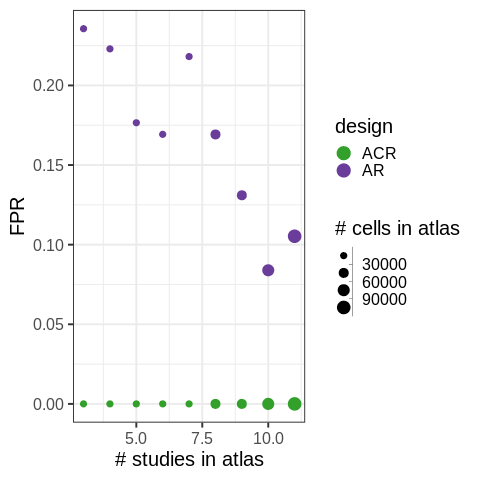

In [87]:
%%R
tpr_res_df_all %>%
ggplot(aes(n_studies, FPR, color=design, size=atlas_size)) +
geom_point() +
theme_bw(base_size=20) +
xlab('# studies in atlas') +
scale_size_binned(name='# cells in atlas') +
scale_color_manual(values=design_palette) +
guides(color=guide_legend(override.aes = list(size=6))) +
ggsave(paste0(figdir, 'FPR_bad_atlas.png'), width=8, height=5) +
ggsave(paste0(figdir, 'FPR_bad_atlas.pdf'), width=8, height=5)

In [72]:
tpr_res_df_all

,TP,FP,FN,TN,TPR,FPR,FDR,design,OOR_state_name,n_studies,CT_oi,atlas_size,FNR
0,56,0,36,762,0.608696,0.000000,0.000000,ACR,natural_killer_cell,10.0,natural_killer_cell,65312.0,0.391304
0,160,273,8,5023,0.952381,0.051548,0.630485,AR,natural_killer_cell,10.0,natural_killer_cell,65312.0,0.047619
0,61,0,22,782,0.734940,0.000000,0.000000,ACR,natural_killer_cell,8.0,natural_killer_cell,31630.0,0.265060
0,121,374,3,2318,0.975806,0.138930,0.755556,AR,natural_killer_cell,8.0,natural_killer_cell,31630.0,0.024194
0,70,2,18,779,0.795455,0.002561,0.027778,ACR,natural_killer_cell,4.0,natural_killer_cell,7070.0,0.204545
0,67,216,59,691,0.531746,0.238148,0.763251,AR,natural_killer_cell,4.0,natural_killer_cell,7070.0,0.468254
0,70,0,19,804,0.786517,0.000000,0.000000,ACR,natural_killer_cell,11.0,natural_killer_cell,104314.0,0.213483
0,145,754,0,7759,1.000000,0.088570,0.838710,AR,natural_killer_cell,11.0,natural_killer_cell,104314.0,0.000000
0,67,2,38,759,0.638095,0.002628,0.028986,ACR,natural_killer_cell,9.0,natural_killer_cell,43944.0,0.361905
0,137,203,24,3413,0.850932,0.056139,0.597059,AR,natural_killer_cell,9.0,natural_killer_cell,43944.0,0.149068


In [178]:
atlas_obs = ar_adata.obs[ar_adata.obs['dataset_group'] == 'atlas'].copy()

In [187]:
n_cells_atlas = atlas_obs.groupby(['cell_annotation', 'sample_id', 'dataset_id']).size().reset_index()
n_cells_atlas.columns = ['cell_annotation', 'sample_id', 'dataset_id', 'n_cells']
n_cells_atlas = n_cells_atlas[n_cells_atlas.n_cells > 0]
n_cells_atlas

,cell_annotation,sample_id,dataset_id,n_cells
90,CD14_low_CD16_positive_monocyte,H00049-Ha001E-PBGa,10_1016_j_cell_2022_01_012,31
98,CD14_low_CD16_positive_monocyte,H00052-Ha001E-PBGa,10_1016_j_cell_2022_01_012,18
106,CD14_low_CD16_positive_monocyte,H00053-Ha001E-PBGa,10_1016_j_cell_2022_01_012,5
114,CD14_low_CD16_positive_monocyte,H00054-Ha001E-PBGa,10_1016_j_cell_2022_01_012,22
122,CD14_low_CD16_positive_monocyte,H00058-Ha001E-PBGa,10_1016_j_cell_2022_01_012,18
...,...,...,...,...
11726,platelet,TSP8,10_1101_2021_07_19_452956_blood,11
11734,platelet,TSP10,10_1101_2021_07_19_452956_blood,1
11742,platelet,TSP14,10_1101_2021_07_19_452956_blood,5
11748,platelet,blood 1,10_1038_s41586_020_2922_4_10x,6


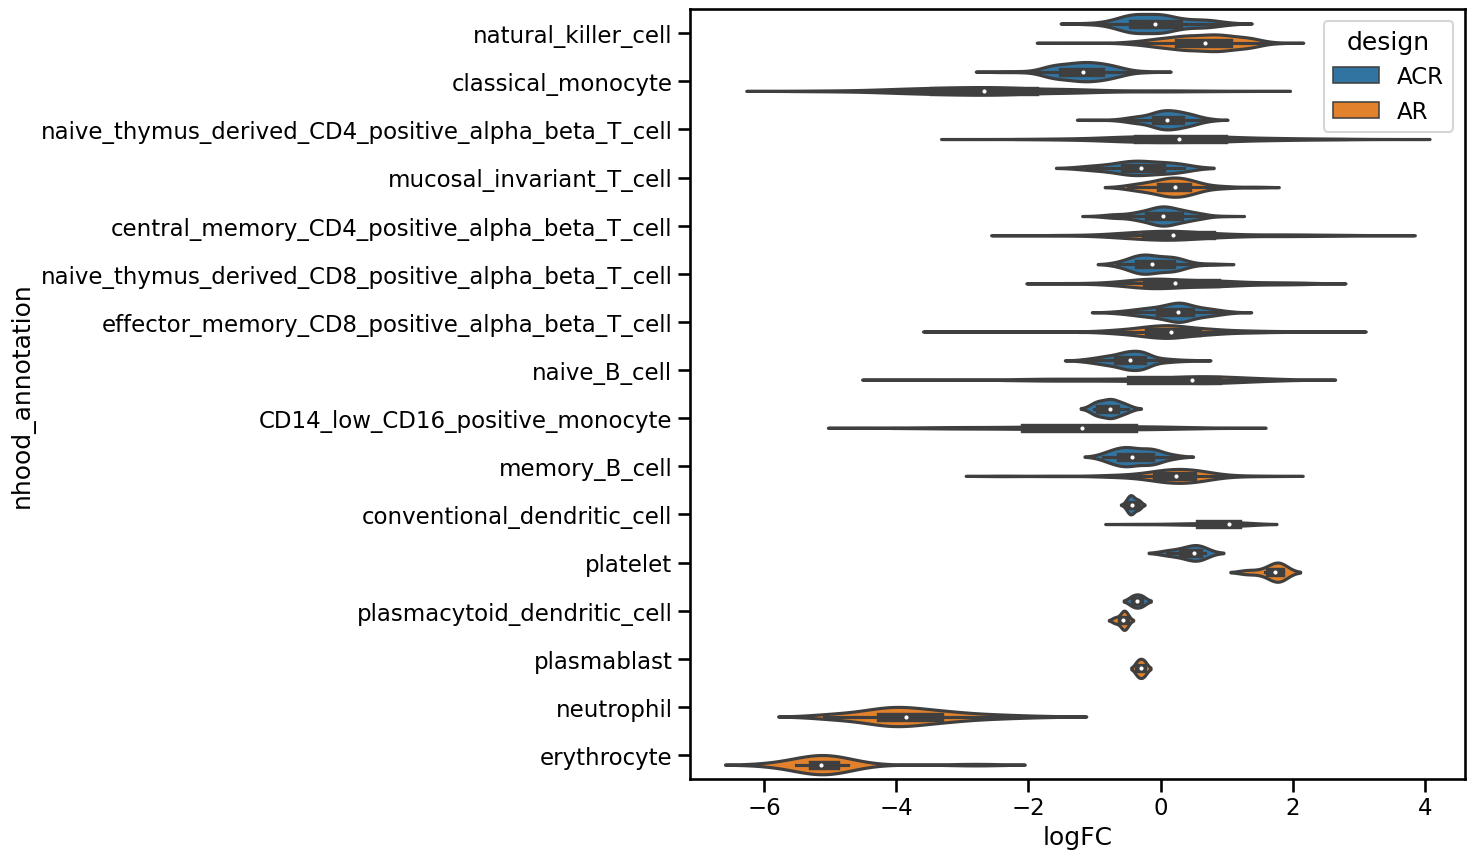

In [177]:
with rc_context({'figure.figsize':[10,10]}):
    sns.violinplot(data=nhoods_res_df, y='nhood_annotation', x='logFC', hue='design')

In [233]:
ct_oi  = 'natural_killer_cell'
all_nhoods_annotations = nhoods_res_df_all.groupby(['n_studies', 'nhood_annotation']).size().reset_index()
all_nhoods_annotations.columns = ['n_studies', 'nhood_annotation', 'n_nhoods']
all_nhoods_annotations.index = [str(x[1]['nhood_annotation']) + "_" + str(x[1]['n_studies']) for x in all_nhoods_annotations.iterrows()]
fp_nhoods = nhoods_res_df_all[(nhoods_res_df_all.SpatialFDR < 0.1) & (nhoods_res_df_all.logFC > 0)]
fp_nhoods_annotations = fp_nhoods.groupby(['n_studies', 'nhood_annotation']).size().reset_index()
fp_nhoods_annotations.index = [str(x[1]['nhood_annotation']) + "_" + str(x[1]['n_studies']) for x in fp_nhoods_annotations.iterrows()]

In [235]:
fp_nhoods_annotations = pd.merge(fp_nhoods_annotations, all_nhoods_annotations)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


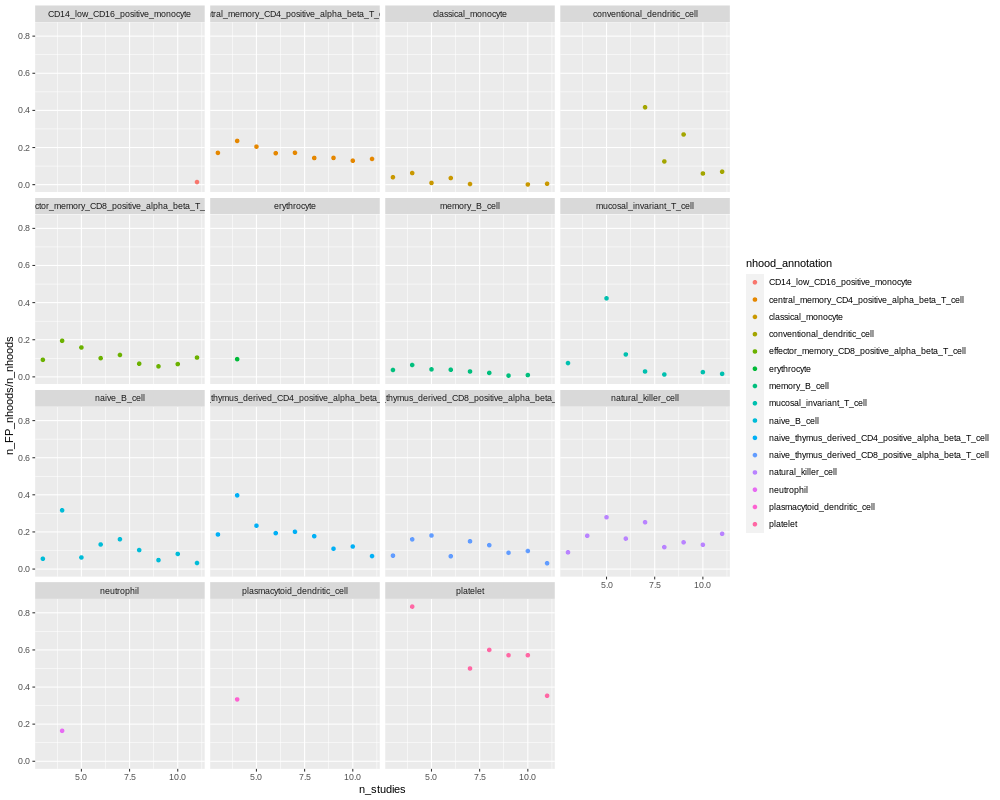

In [236]:
%%R -i fp_nhoods_annotations -w 1000 -h 800
fp_nhoods_annotations %>%
    rename(n_FP_nhoods=`0`) %>%
    ggplot(aes(n_studies, n_FP_nhoods/n_nhoods, color=nhood_annotation)) +
    geom_point() +
    facet_wrap(nhood_annotation~.)

### With OOR population
(Check for false negatives)

In [ ]:
nhoods_res_df_all = pd.DataFrame()
tpr_res_df_all = pd.DataFrame()
auprc_df_all = pd.DataFrame()

for d in [x for x in os.listdir(outdir) if x.endswith("withOOR") and 'keep' in x]:
    n_studies = int(d.split('keep')[1].split('studies')[0])
    ct_oi = d.split('removeby')[-1].strip("_withOOR")
    print(f'{ct_oi}, {n_studies} studies')
    if os.path.exists(outdir + d + '/acr_design.h5ad'):
        acr_adata = milopy.utils.read_milo_adata(outdir + d + '/acr_design.h5ad', backed=True)
        ar_adata = milopy.utils.read_milo_adata(outdir + d + '/ar_design.h5ad', backed=True)
        atlas_size = sum(ar_adata.obs['dataset_group'] == 'atlas')
        nhoods_df_acr, tpr_df_acr, auprc_df_acr = parse_design(acr_adata, ct_oi, 'ACR')
        nhoods_df_ar, tpr_df_ar, auprc_df_ar = parse_design(ar_adata, ct_oi, 'AR')
        ## store results
        nhoods_res_df = pd.concat([nhoods_df_acr, nhoods_df_ar])
        tpr_res_df = pd.concat([tpr_df_acr, tpr_df_ar])
        auprc_df = pd.concat([auprc_df_acr, auprc_df_ar])
        nhoods_res_df['n_studies'] = n_studies
        nhoods_res_df['CT_oi'] = ct_oi
        tpr_res_df['n_studies'] = n_studies
        tpr_res_df['CT_oi'] = ct_oi
        tpr_res_df['atlas_size'] = atlas_size
        auprc_df['n_studies'] = n_studies
        auprc_df['CT_oi'] = ct_oi
        auprc_df['atlas_size'] = atlas_size
        nhoods_res_df_all = pd.concat([nhoods_res_df_all, nhoods_res_df])
        tpr_res_df_all = pd.concat([tpr_res_df_all, tpr_res_df])
        auprc_df_all = pd.concat([auprc_df_all, auprc_df])

natural_killer_cell, 10 studies
classical_monocyte, 12 studies
platele, 11 studies
memory_B_cell, 9 studies
central_memory_CD4_positive_alpha_beta_T_cell, 7 studies
platele, 5 studies
classical_monocyte, 5 studies
natural_killer_cell, 8 studies
CD14_low_CD16_positive_monocyte, 12 studies
platele, 7 studies
naive_thymus_derived_CD4_positive_alpha_beta_T_cell, 8 studies
naive_thymus_derived_CD4_positive_alpha_beta_T_cell, 1 studies
central_memory_CD4_positive_alpha_beta_T_cell, 8 studies
platele, 8 studies
naive_B_cell, 3 studies
classical_monocyte, 2 studies
platele, 9 studies
effector_memory_CD8_positive_alpha_beta_T_cell, 11 studies
platele, 4 studies
CD14_low_CD16_positive_monocyte, 11 studies
effector_memory_CD8_positive_alpha_beta_T_cell, 6 studies
effector_memory_CD8_positive_alpha_beta_T_cell, 4 studies
naive_thymus_derived_CD4_positive_alpha_beta_T_cell, 5 studies
CD14_low_CD16_positive_monocyte, 1 studies
natural_killer_cell, 1 studies
memory_B_cell, 4 studies
classical_monocyt

In [ ]:
tpr_res_df_all['FNR'] = tpr_res_df_all['FN'] / (tpr_res_df_all['FN'] + tpr_res_df_all['TP'])

In [ ]:
auprc_df_all.to_csv(outdir + 'AUPRC_table.with_OOR.csv')

In [ ]:
tpr_res_df_all.to_csv(outdir + 'TPR_table.with_OOR.csv')


In [88]:
tpr_res_df_all = pd.read_csv(outdir + 'TPR_table.with_OOR.csv', index_col=0)

In [19]:
for d in [x for x in os.listdir(outdir) if x.endswith("withOOR")]:
    if os.path.exists(outdir + d + '/cr_design.h5ad'):
        n_studies = int(d.split('keep')[1].split('studies')[0])
        ct_oi = d.split('removeby')[-1].strip("_withOOR")
        cr_adata = milopy.utils.read_milo_adata(outdir + d + '/cr_design.h5ad', backed=False)
        nhoods_df_cr, tpr_df_cr, _ = parse_design(cr_adata, ct_oi, 'CR')
        tpr_df_cr['CT_oi'] = ct_oi
        tpr_df_cr['design'] = 'CR'
        tpr_res_df_all = pd.concat([tpr_res_df_all, tpr_df_cr])

In [20]:
tpr_res_df_all

,TP,FP,FN,TN,TPR,FPR,FDR,design,OOR_state_name,n_studies,CT_oi,atlas_size,FNR
0,56,0,36,762,0.608696,0.000000,0.000000,ACR,natural_killer_cell,10.0,natural_killer_cell,65312.0,0.391304
0,70,831,0,4572,1.000000,0.153803,0.922309,AR,natural_killer_cell,10.0,natural_killer_cell,65312.0,0.000000
0,19,0,6,910,0.760000,0.000000,0.000000,ACR,classical_monocyte,12.0,classical_monocyte,546567.0,0.240000
0,36,3275,0,43144,1.000000,0.070553,0.989127,AR,classical_monocyte,12.0,classical_monocyte,546567.0,0.000000
0,0,0,10,975,0.000000,0.000000,0.000000,ACR,platele,11.0,platele,114299.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,13,974,0.000000,0.000000,0.000000,CR,CD14_low_CD16_positive_monocyte,NaN,CD14_low_CD16_positive_monocyte,NaN,NaN
0,0,0,106,867,0.000000,0.000000,0.000000,CR,memory_B_cell,NaN,memory_B_cell,NaN,NaN
0,21,23,8,881,0.724138,0.025442,0.522727,CR,classical_monocyte,NaN,classical_monocyte,NaN,NaN
0,57,20,38,784,0.600000,0.024876,0.259740,CR,natural_killer_cell,NaN,natural_killer_cell,NaN,NaN


In [21]:
# ## Get OOR state population size
# n_querys = 7
# oor_state_size = {}
# for d in os.listdir(outdir):
#     if not d.endswith('.h5ad') and d.startswith('qPBMC'):
#         if 'neutrophil' not in d:
#             acr_adata = sc.read_h5ad(outdir + d +'/acr_design.h5ad', backed=True)
#             ct = acr_adata.obs[acr_adata.obs['OOR_state']==1]['cell_type'].unique()[0]
#             sample_querys = acr_adata.obs[acr_adata.obs['cell_type'] == ct].value_counts(
#         'donor_id')[0:n_querys].index.values
#             oor_state_size[ct] = acr_adata[acr_adata.obs['donor_id'].isin(sample_querys)].obs['OOR_state'].sum()

oor_state_size = {'memory_B_cell': 299,
 'conventional_dendritic_cell': 88,
 'naive_B_cell': 485,
 'central_memory_CD4_positive_alpha_beta_T_cell': 1251,
 'plasmablast': 11,
 'platelet': 105,
 'plasmacytoid_dendritic_cell': 35,
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell': 549,
 'classical_monocyte': 287,
 'erythrocyte': 10,
 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell': 297,
 'natural_killer_cell': 676,
 'effector_memory_CD8_positive_alpha_beta_T_cell': 939,
 'mucosal_invariant_T_cell': 142,
 'CD14_low_CD16_positive_monocyte': 117}

In [22]:
tpr_res_df_all = tpr_res_df_all[tpr_res_df_all.CT_oi != 'platele']

In [23]:
tpr_res_df_all['OOR_state_size'] = [oor_state_size[x] for x in tpr_res_df_all['CT_oi']]

/tmp/ipykernel_10316/3719966603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tpr_res_df_all['OOR_state_size'] = [oor_state_size[x] for x in tpr_res_df_all['CT_oi']]


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


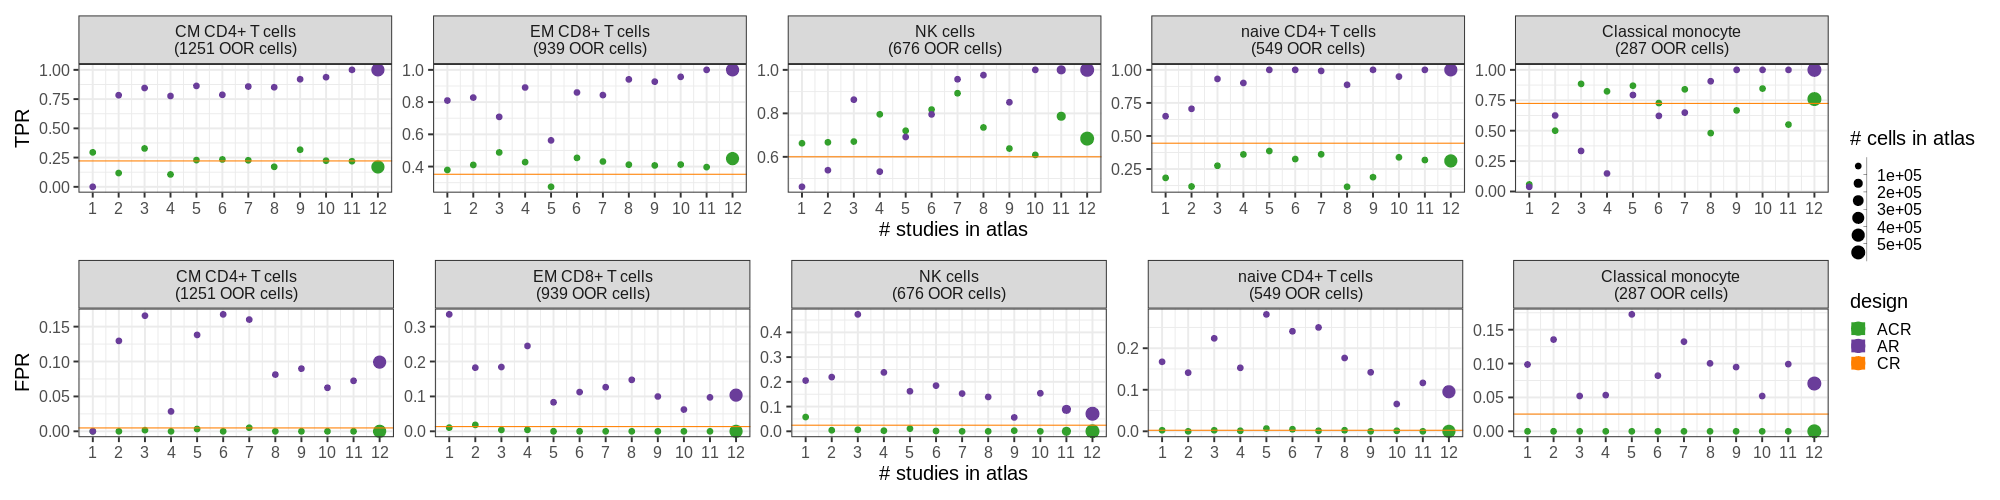

In [24]:
%%R -i tpr_res_df_all -w 2000 -h 500 
library(patchwork)


ct_labeller <- c(
     'natural_killer_cell' = 'NK cells',
     'classical_monocyte' = 'Classical monocyte',
    'CD14_low_CD16_positive_monocyte' = 'Non-classical monocyte',
    'central_memory_CD4_positive_alpha_beta_T_cell' = 'CM CD4+ T cells',
    'effector_memory_CD8_positive_alpha_beta_T_cell' = 'EM CD8+ T cells',
    'naive_thymus_derived_CD4_positive_alpha_beta_T_cell' = 'naive CD4+ T cells'
)

## Keep states with top TPR in full simulation
keep_states = c(
    'central_memory_CD4_positive_alpha_beta_T_cell',
    'classical_monocyte',
    'effector_memory_CD8_positive_alpha_beta_T_cell',
    'natural_killer_cell',
    'naive_thymus_derived_CD4_positive_alpha_beta_T_cell'
)

rev_ct_labeller <- setNames(ct_labeller, names(ct_labeller))

p1 <- tpr_res_df_all %>%
    filter(CT_oi %in% keep_states) %>%
    mutate(CT_oi = paste0(rev_ct_labeller[CT_oi], '\n(', OOR_state_size,' OOR cells)')) %>%
    arrange(- OOR_state_size) %>%
    mutate(CT_oi = factor(CT_oi, levels=unique(CT_oi))) %>%
    ggplot(aes(n_studies, TPR, color=design, size=atlas_size)) +
    geom_point(data = . %>% filter(design != 'CR')) +
    facet_wrap(CT_oi~., scales='free', nrow=1) +
    theme_bw(base_size=20) +
    xlab('# studies in atlas') +
    scale_x_continuous(breaks = seq(1, 12)) +
    geom_hline(data= . %>% filter(design == 'CR'), aes(yintercept = TPR, color=design)) +
    scale_size_binned(name='# cells in atlas') +
    scale_color_manual(values=design_palette) +
    guides(color=guide_legend(override.aes = list(size=6))) 

p2 <- tpr_res_df_all %>%
    filter(CT_oi %in% keep_states) %>%
    mutate(CT_oi = paste0(rev_ct_labeller[CT_oi], '\n(', OOR_state_size,' OOR cells)')) %>%
    arrange(- OOR_state_size) %>%
    mutate(CT_oi = factor(CT_oi, levels=unique(CT_oi))) %>%    
    ggplot(aes(n_studies, FPR, color=design, size=atlas_size)) +
    geom_point(data = . %>% filter(design != 'CR')) +
    facet_wrap(CT_oi ~ ., scales='free', nrow=1) +
    theme_bw(base_size=20) +
    xlab('# studies in atlas') +
    scale_x_continuous(breaks = seq(1, 12)) +
    geom_hline(data= . %>% filter(design == 'CR'), aes(yintercept = FPR, color=design)) +
    scale_size_binned(name='# cells in atlas') +
    scale_color_manual(values=design_palette) +
    guides(color=guide_legend(override.aes = list(size=6))) 

(p1 / p2) + plot_layout(guides='collect') +
    ggsave(paste0(figdir, 'bad_atlas_withOOR.png'), width=24, height=8) +
    ggsave(paste0(figdir, 'bad_atlas_withOOR.pdf'), width=24, height=8)

In [25]:
%%R 
summary(lm(data=tpr_res_df_all[tpr_res_df_all$design == 'AR',], formula = n_studies ~ CT_oi + TPR ))


Call:
lm(formula = n_studies ~ CT_oi + TPR, data = tpr_res_df_all[tpr_res_df_all$design == 
    "AR", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.9810 -1.9524 -0.0338  1.8181  4.6616 

Coefficients:
                                                         Estimate Std. Error
(Intercept)                                                2.6358     0.7723
CT_oicentral_memory_CD4_positive_alpha_beta_T_cell        -4.3297     1.0476
CT_oiclassical_monocyte                                   -3.0470     1.0081
CT_oieffector_memory_CD8_positive_alpha_beta_T_cell       -4.9314     1.0702
CT_oimemory_B_cell                                        -2.1747     0.9886
CT_oinaive_B_cell                                         -5.0001     1.0729
CT_oinaive_thymus_derived_CD4_positive_alpha_beta_T_cell  -5.5178     1.0945
CT_oinatural_killer_cell                                  -4.3675     1.0490
TPR                                                       10.2204     0.9467
               

In [26]:
%%R
summary(lm(data=tpr_res_df_all[tpr_res_df_all$design == 'ACR',], formula = n_studies ~ CT_oi + TPR ))


Call:
lm(formula = n_studies ~ CT_oi + TPR, data = tpr_res_df_all[tpr_res_df_all$design == 
    "ACR", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9174 -3.0406 -0.4383  2.9738  5.7778 

Coefficients:
                                                         Estimate Std. Error
(Intercept)                                               6.50000    1.02960
CT_oicentral_memory_CD4_positive_alpha_beta_T_cell       -1.22430    1.62221
CT_oiclassical_monocyte                                  -3.72031    2.61584
CT_oieffector_memory_CD8_positive_alpha_beta_T_cell      -2.29598    1.97960
CT_oimemory_B_cell                                       -0.06833    1.45662
CT_oinaive_B_cell                                        -0.87054    1.54231
CT_oinaive_thymus_derived_CD4_positive_alpha_beta_T_cell -1.52558    1.70712
CT_oinatural_killer_cell                                 -4.03212    2.76901
TPR                                                       5.57664    3.25746
              

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


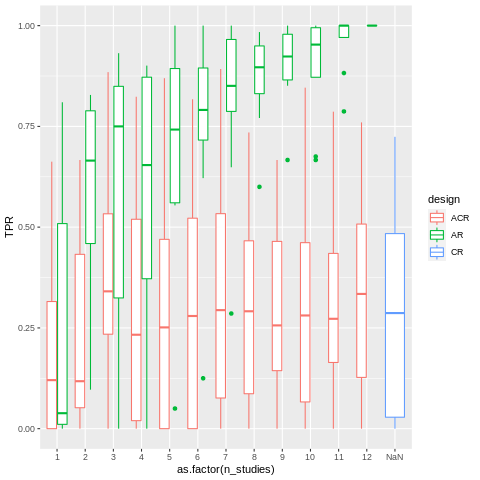

In [27]:
%%R -i tpr_res_df_all
tpr_res_df_all %>%
ggplot(aes(as.factor(n_studies), TPR, color=design)) +
geom_boxplot()

In [568]:
def get_adj_dataset_entropy(ct_size, remove_dataset, OOR_state_name):
    '''
    From https://www.frontiersin.org/articles/10.3389/fgene.2022.855076/full#:~:text=all%2043%20Articles-,Cell%20Type%20Diversity%20Statistic%3A%20An%20Entropy%2DBased%20Metric%20to%20Compare,Cell%20Type%20Composition%20Across%20Samples&text=Changes%20of%20cell%20type%20composition,into%20disease%20and%20other%20conditions.
    '''
#     pseudoprob = 0.00000000000000000001
    n_cells = ct_size[(ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]['n_cells']
    n_cells = n_cells[n_cells > 0]
    n_s = n_cells.sum()
    p_i_s = n_cells/n_s
    k = len(p_i_s)
    adj_entropy = (- sum(p_i_s * np.log(p_i_s) ) / np.log(k) ) - 1
    return(adj_entropy)

In [614]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/suboptimal_atlas_analysis/'

In [616]:
simdirs = [x for x in os.listdir(outdir) if x.startswith('suboptimal')]
keep_cols = ['Recall', 'Precision', 'AUPRC', 'no_skill_thresh', 'design', 'OOR_state_name', 'atlas_size']
auprc_df_all = pd.DataFrame()
for s in simdirs:
    try:
        auprc_df = pd.read_csv(outdir + s +'/auprc_df.csv', index_col=0)
        auprc_df_all = pd.concat([auprc_df_all, auprc_df])
    except FileNotFoundError:
        continue

auprc_df_all['OOR_state_name'] = auprc_df_all['OOR_state_name'].str.split("_withOOR", expand=True)[0]
auprc_df_all['OOR_state_name_pl'] = [short_pop_names[x] for x in auprc_df_all['OOR_state_name']]

auprc_df_min = auprc_df_all.drop_duplicates(['AUPRC', 'no_skill_thresh', 'design', 'OOR_state_name', 'atlas_size'])

In [619]:
simdirs = [x for x in os.listdir(outdir) if x.startswith('suboptimal')]
tpr_df_all = pd.DataFrame()
for s in simdirs:
    try:
        tpr_df = pd.read_csv(outdir + s +'/tpr_res_df.csv', index_col=0)
        tpr_df_all = pd.concat([tpr_df_all, tpr_df])
    except FileNotFoundError:
        continue

tpr_df_all['OOR_state_name'] = tpr_df_all['OOR_state_name'].str.split("_withOOR", expand=True)[0]

tpr_df_all['OOR_state_name_pl'] = [short_pop_names[x] for x in tpr_df_all['OOR_state_name']]

In [623]:
auprc_df_min = pd.merge(auprc_df_min, tpr_df_all[['TPR', 'FPR', 'design', "OOR_state_name", 'n_studies', 'atlas_size','OOR_state_name_pl']])

In [624]:
%%R -i auprc_df_min
head(auprc_df_min)

  Recall    Precision     AUPRC no_skill_thresh design      OOR_state_name
0      1 0.1077283372 0.8934424    0.1077283372    ACR natural_killer_cell
1      1 0.0127900603 0.6697585    0.0127900603     AR natural_killer_cell
2      1 0.0267379679 0.8692393    0.0267379679    ACR  classical_monocyte
3      1 0.0007749435 0.9629173    0.0007749435     AR  classical_monocyte
4      1 0.0101522843 0.6646786    0.0101522843    ACR            platelet
5      1 0.0007455533 0.1129371    0.0007455533     AR            platelet
  n_studies atlas_size                       CT_oi  OOR_state_name_pl       TPR
0        10      65312 natural_killer_cell_withOOR                 NK 0.6086957
1        10      65312 natural_killer_cell_withOOR                 NK 1.0000000
2        12     546567  classical_monocyte_withOOR classical monocyte 0.7600000
3        12     546567  classical_monocyte_withOOR classical monocyte 1.0000000
4        11     114299            platelet_withOOR           platelet 0.000

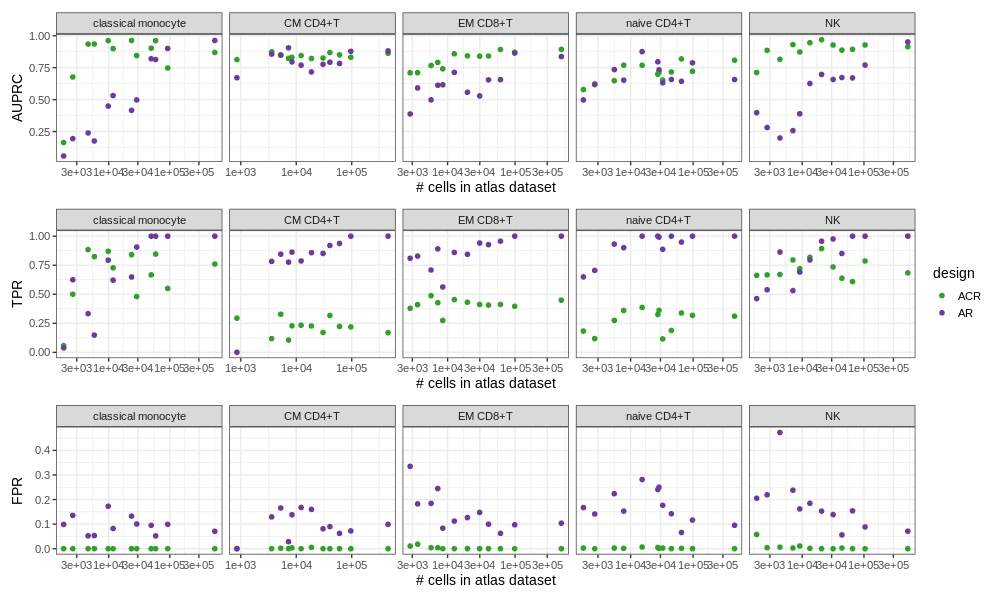

In [636]:
%%R -w 1000 -h 600
cts_oi <- c('CM CD4+T', 'EM CD8+T', 'NK', 'naive CD4+T', 'classical monocyte')

pl_ls <- lapply(c('AUPRC', 'TPR', 'FPR'), function(m) {auprc_df_min %>%
    filter(OOR_state_name_pl %in% cts_oi) %>%
    rename(metric = m) %>%
    ggplot(aes(atlas_size, metric, color=design)) +
    geom_point(size=2) +
    scale_x_log10() +
    facet_wrap(OOR_state_name_pl~., scales='free_x', nrow=1) +
    scale_color_manual(values=design_palette) +
#     ggpubr::stat_cor() +
    ylab(m) +
    xlab('# cells in atlas dataset') +
    theme_bw(base_size=14) })
    # ggsave(paste0(figdir, 'atlas_size_ncells'))
    
wrap_plots(pl_ls) + 
plot_layout(ncol=1, guides='collect') +
ggsave(paste0(figdir, 'atlas_size_metrics_facets.pdf'), width=16, height=11) +
ggsave(paste0(figdir, 'atlas_size_metrics_facets.png'), width=16, height=11)

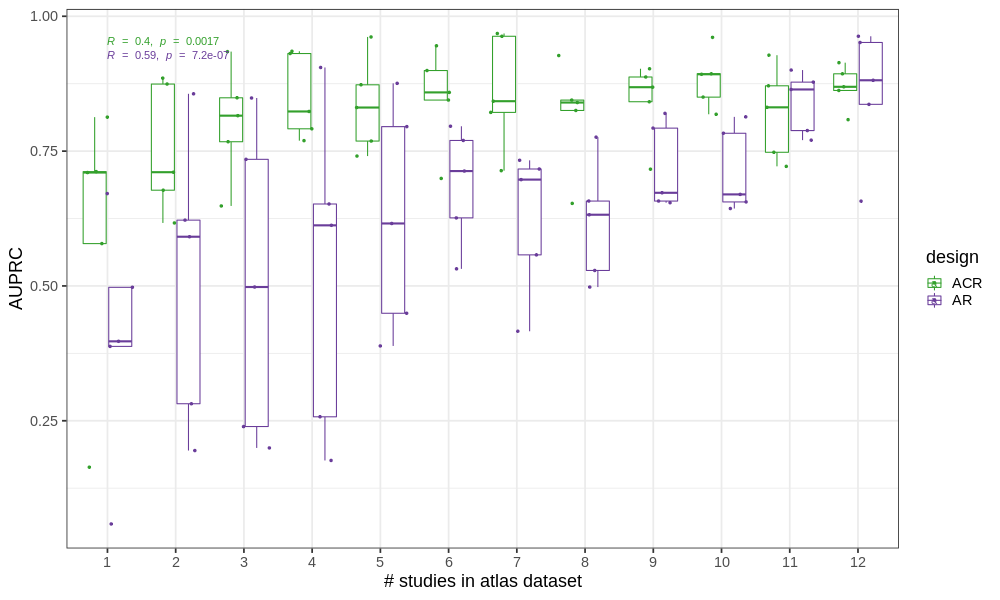

In [552]:
%%R -w 1000 -h 600
cts_oi <- c('CM CD4+T', 'EM CD8+T', 'NK', 'naive CD4+T', 'classical monocyte'
           )

auprc_df_min %>%
filter(OOR_state_name_pl %in% cts_oi) %>%
ggplot(aes(as.factor(n_studies), AUPRC, color=design)) +
geom_boxplot(outlier.alpha=0) +
geom_point(size=1, position=position_jitterdodge()) +
# facet_wrap(OOR_state_name_pl~., scales='free_x') +
scale_color_manual(values=design_palette) +
ggpubr::stat_cor(aes(x=n_studies)) +
xlab('# studies in atlas dataset') +
theme_bw(base_size=18) +
ggsave(paste0(figdir, 'AUPRC_atlas_size.pdf'), width=10, height=6)

In [543]:
# %%R 
# auprc_df_min %>%
#     # filter(atlas_size < 4e+05) %>%
#     filter(OOR_state_name_pl %in% cts_oi) %>%
#     select(OOR_state_name_pl, design, atlas_size, AUPRC, n_studies) %>%
#     group_by(OOR_state_name_pl, design) %>%
#     summarise(
#         cor_n_cells = Hmisc::rcorr(log10(atlas_size), AUPRC)$r[1,2], pval_cor_n_cells = Hmisc::rcorr(log10(atlas_size), AUPRC)$P[1,2],
#         cor_n_studies = Hmisc::rcorr(n_studies, AUPRC)$r[1,2], pval_cor_n_studies = Hmisc::rcorr(n_studies, AUPRC)$P[1,2]
#     ) %>%
#     ggplot(aes(design, OOR_state_name_pl, fill=cor_n_cells)) +
#     geom_point(shape=21, aes(size=-log10(pval_cor_n_cells))) +
#     scale_fill_distiller(palette='Reds', direction=1)
#     # geom_point() +
#     # ggpubr::stat_cor() +
#     # facet_wrap(CT_oi~., scales='free')

## Leave-one-out robustness

In [630]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/suboptimal_atlas_analysis/'

In [631]:
ct_size = pd.read_csv(outdir + 'atlas_datasets_ncells_ct.csv', index_col=0)

In [632]:
simdirs = [x for x in os.listdir(outdir) if x.startswith('leaveoneout')]
keep_cols = ['Recall', 'Precision', 'AUPRC', 'no_skill_thresh', 'design', 'OOR_state_name', 'remove_dataset']
auprc_df_all = pd.DataFrame()
for s in simdirs:
    try:
        auprc_df = pd.read_csv(outdir + s +'/auprc_df.csv', index_col=0)
        auprc_df_all = pd.concat([auprc_df_all, auprc_df[keep_cols]])
    except:
        continue

# read results without missing dataset
OOR_states = auprc_df_all.OOR_state_name.unique()

for ct in OOR_states:
    simdir = f'/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'
    auprc_full = pd.read_csv(simdir + 'AUPRC_res.milo.csv', index_col=0)
    auprc_full = auprc_full[auprc_full['design'] == 'ACR'].copy()
    auprc_full['remove_dataset'] = 'none'
    auprc_df_all = pd.concat([auprc_df_all, auprc_full[keep_cols]])

In [633]:
auprc_df_all['OOR_state_name_pl'] = [short_pop_names[x] for x in auprc_df_all['OOR_state_name']]

In [634]:
## Same excluded from main figures
exclude_cts = ['CD14_low_CD16_positive_monocyte', 'conventional_dendritic_cell',
       'erythrocyte', 'mucosal_invariant_T_cell', 'plasmablast',
       'plasmacytoid_dendritic_cell', 'platelet']

In [635]:
auprc_df_all = auprc_df_all[~auprc_df_all.OOR_state_name.isin(exclude_cts)]

In [636]:
%%R -i auprc_df_all
head(auprc_df_all)

  Recall Precision     AUPRC no_skill_thresh design
1      1 0.2584270 0.9016692        0.258427    ACR
2      1 0.2587177 0.9016692        0.258427    ACR
3      1 0.2590090 0.9016692        0.258427    ACR
4      1 0.2593010 0.9016692        0.258427    ACR
5      1 0.2595937 0.9016692        0.258427    ACR
6      1 0.2598870 0.9016692        0.258427    ACR
                                  OOR_state_name  remove_dataset
1 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
2 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
3 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
4 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
5 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
6 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
  OOR_state_name_pl
1          EM CD8+T
2          EM CD8+T
3          EM CD8+T
4          EM CD8+T
5          EM CD8+T
6          EM CD8+T


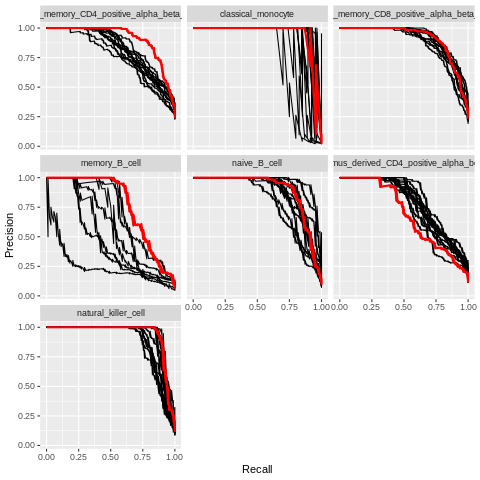

In [615]:
%%R
auprc_df_all %>%
ggplot(aes(Recall, Precision,group=remove_dataset)) +
geom_line() +
geom_line(data=. %>% filter(remove_dataset == 'none'), color='red', size=1) +
facet_wrap(OOR_state_name~.)

In [637]:
def get_atlas_ncells(ct_size, remove_dataset, OOR_state_name):
    tot_cells = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]['n_cells'].sum()
    return(tot_cells)

def get_atlas_ndonors(ct_size, remove_dataset, OOR_state_name):
    tot_cells = ct_size[ct_size['dataset_id'] != remove_dataset].drop_duplicates(['dataset_id','n_donors'])['n_donors'].sum()
    return(tot_cells)


def get_atlas_nmonos(ct_size, remove_dataset, OOR_state_name):
    tot_cells = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]['n_cells'].sum()
    mono_cells = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'].isin( ['naive_B_cell']))]['n_cells'].sum()
    return(mono_cells/tot_cells)


auprc_df_min = auprc_df_all.drop_duplicates(['remove_dataset', "OOR_state_name", 'AUPRC']).copy()
auprc_df_min['ncells_atlas_total'] = [get_atlas_ncells(ct_size, x['remove_dataset'], x['OOR_state_name']) for i,x in auprc_df_min.iterrows()]
auprc_df_min['ndonors_atlas_total'] = [get_atlas_ndonors(ct_size, x['remove_dataset'], x['OOR_state_name']) for i,x in auprc_df_min.iterrows()]
auprc_df_min['nmonos_atlas_total'] = [get_atlas_nmonos(ct_size, x['remove_dataset'], x['OOR_state_name']) for i,x in auprc_df_min.iterrows()]
auprc_df_min['remove_dataset_size'] = [ct_size[ct_size['dataset_id'] == x['remove_dataset']].n_cells.sum() for i,x in auprc_df_min.iterrows()]
auprc_df_min['remove_dataset_ndonors'] = [ct_size[ct_size['dataset_id'] == x['remove_dataset']].n_donors.sum() for i,x in auprc_df_min.iterrows()]
auprc_df_min['OOR_state_size'] = [oor_state_size[x] for x in auprc_df_min['OOR_state_name']]

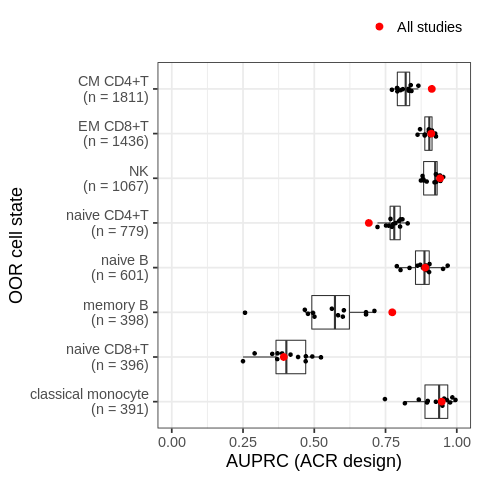

In [642]:
%%R -i auprc_df_min
# pl_df <- auprc_df_all %>%
# distinct(AUPRC, remove_dataset, OOR_state_name_pl) 

auprc_df_min %>%
mutate(OOR_state_name_pl =paste0(OOR_state_name_pl, '\n(n = ', OOR_state_size, ')')) %>%
arrange(OOR_state_size) %>%
mutate(OOR_state_name_pl = factor(OOR_state_name_pl, levels=unique(OOR_state_name_pl))) %>%
ggplot(aes(OOR_state_name_pl, AUPRC)) +
geom_boxplot(data=. %>% filter(remove_dataset != 'none'), outlier.alpha=0) +
geom_jitter(data=. %>% filter(remove_dataset != 'none'), width=0.1) +
geom_point(data=. %>% filter(remove_dataset == 'none'), aes(color='All studies'), size=3) +
scale_color_manual(values=c('All studies'='red'), name='') +
ylim(0,1) +
coord_flip() +
xlab("OOR cell state") + ylab("AUPRC (ACR design)") +
theme_bw(base_size=18) +
theme(legend.position='top', legend.justification=1) +
ggsave(paste0(figdir, 'leaveoneout_oor_state_boxplot.pdf'), width=8, height=7)

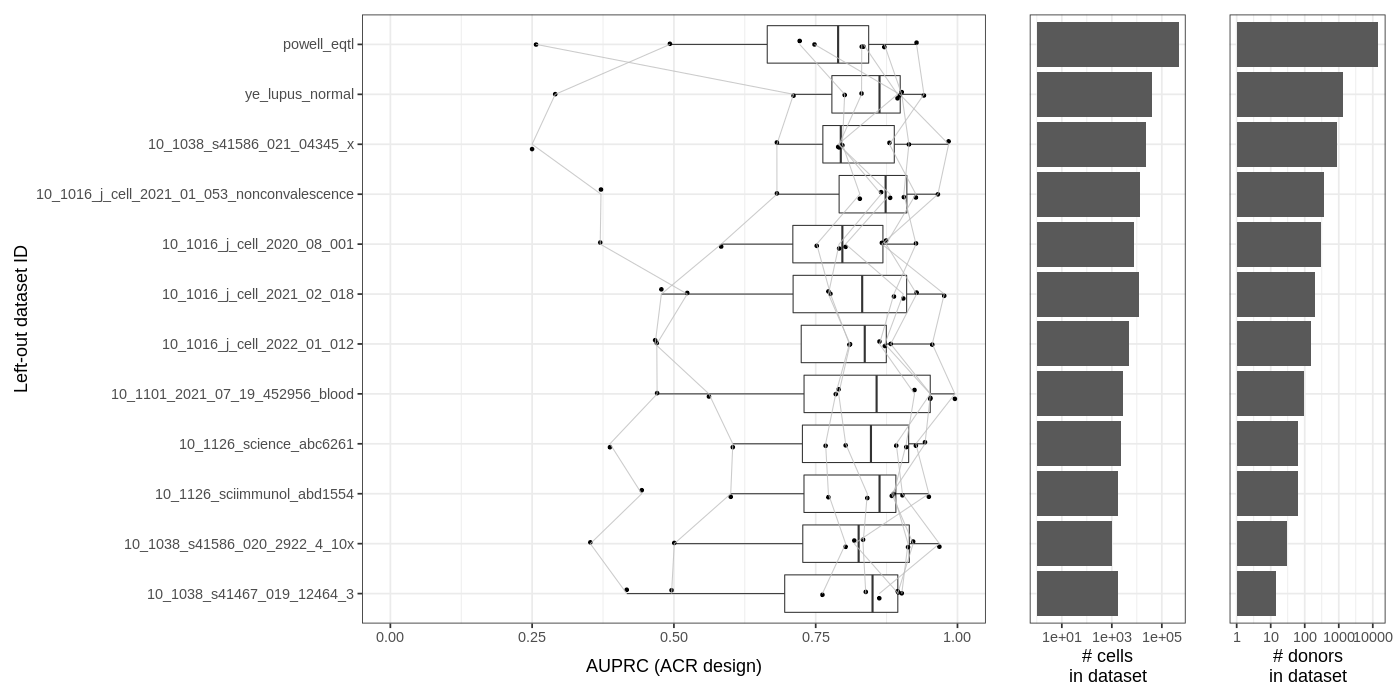

In [653]:
%%R -i auprc_df_min -w 1400 -h 700
library(patchwork)

pl_df <- auprc_df_min %>%
    distinct(AUPRC, remove_dataset, OOR_state_name_pl, remove_dataset_ndonors, remove_dataset_size) %>%
    arrange(remove_dataset_ndonors) %>%
    filter(remove_dataset != 'none') %>%
    mutate(remove_dataset=factor(remove_dataset, levels=unique(remove_dataset))) 

p1 <- pl_df %>%
    ggplot(aes(remove_dataset, AUPRC)) +
    geom_boxplot(outlier.alpha=0) +
    geom_jitter(width=0.1) +
    geom_line(aes(group = OOR_state_name_pl), color='grey', size=0.5, alpha=0.8) +
    ylim(0,1) +
    coord_flip() +
    xlab('Left-out dataset ID') +
    ylab("AUPRC (ACR design)") +
    # facet_wrap(OOR_state_name_pl~.) +
    theme_bw(base_size=18)
    
pl2 <- pl_df %>%
    group_by(remove_dataset) %>%
    summarise(remove_dataset_size = first(remove_dataset_size)) %>%
    ggplot(aes(remove_dataset, remove_dataset_size)) + geom_col() +
    coord_flip() +
    scale_y_log10() +
    theme_bw(base_size=18) +
    xlab('') + ylab('# cells\nin dataset') +
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) 
    
pl3 <- pl_df %>%
    group_by(remove_dataset) %>%
    summarise(remove_dataset_ndonors = first(remove_dataset_ndonors)) %>%
    ggplot(aes(remove_dataset, remove_dataset_ndonors)) + geom_col() +
    coord_flip() +
    scale_y_log10() +
    theme_bw(base_size=18) +
    xlab('') + ylab('# donors\nin dataset') +
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) 
    
(p1 | pl2 | pl3 ) + plot_layout(widths=c(4,1,1)) +
ggsave(paste0(figdir, 'leaveoneout_dataset_size_fig.pdf'), width=16, height=8)

Make some figures for the reviewer

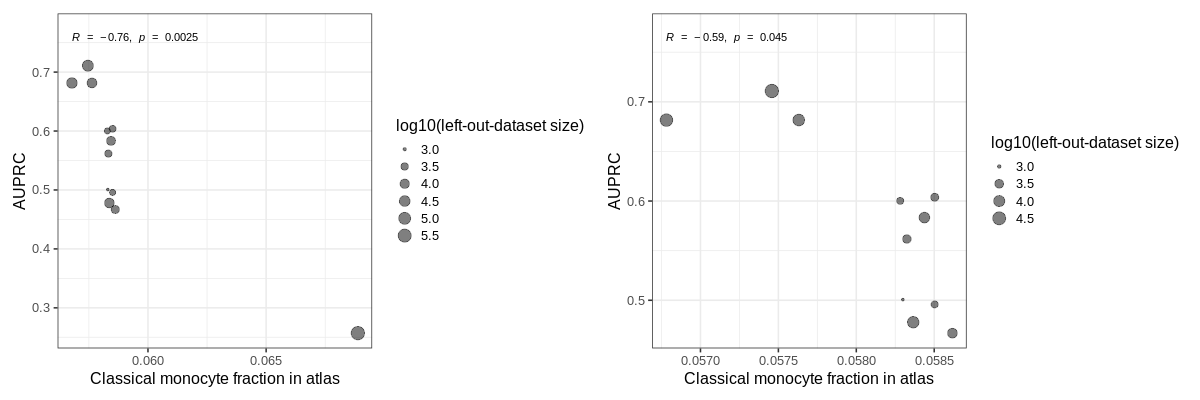

In [643]:
%%R -w 1200 -h 400
p1 <- auprc_df_min %>%
filter(OOR_state_name == 'memory_B_cell') %>%
# filter(remove_dataset!='powell_eqtl') %>%
ggplot(aes(nmonos_atlas_total, AUPRC)) +
geom_point(alpha=0.5, aes(size=log10(remove_dataset_size))) +
# facet_wrap(OOR_state_name_pl~., scales='free', labeller='label_both') +
theme_bw(base_size=16) +
ggpubr::stat_cor() +
scale_size(name='log10(left-out-dataset size)') +
xlab('Classical monocyte fraction in atlas')

p2 <- auprc_df_min %>%
filter(OOR_state_name == 'memory_B_cell') %>%
filter(remove_dataset!='powell_eqtl') %>%
ggplot(aes(nmonos_atlas_total, AUPRC)) +
geom_point(alpha=0.5, aes(size=log10(remove_dataset_size))) +
# facet_wrap(OOR_state_name_pl~., scales='free', labeller='label_both') +
theme_bw(base_size=16) +
scale_size(name='log10(left-out-dataset size)') +
ggpubr::stat_cor() +
xlab('Classical monocyte fraction in atlas')

(p1 | p2) +
ggsave(paste0(figdir, 'reviewer_fig_AUPRC_leaveoneout_CD14lo_monos.png'), width=15, height=5) +
ggsave(paste0(figdir, 'reviewer_fig_AUPRC_leaveoneout_CD14lo_monos.pdf'), width=15, height=5)

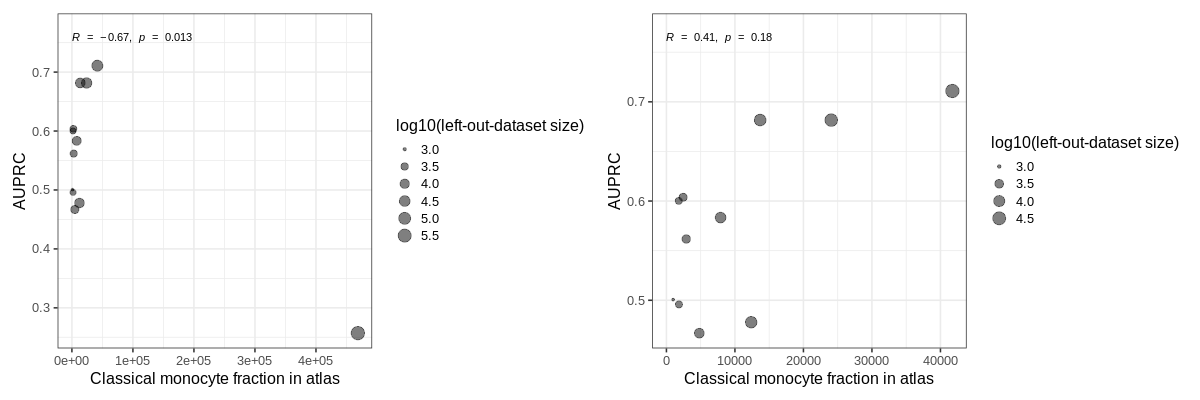

In [651]:
%%R -w 1200 -h 400
p1 <- auprc_df_min %>%
filter(OOR_state_name == 'memory_B_cell') %>%
# filter(remove_dataset!='powell_eqtl') %>%
ggplot(aes(remove_dataset_size, AUPRC)) +
geom_point(alpha=0.5, aes(size=log10(remove_dataset_size))) +
# facet_wrap(OOR_state_name_pl~., scales='free', labeller='label_both') +
theme_bw(base_size=16) +
ggpubr::stat_cor() +
scale_size(name='log10(left-out-dataset size)') +
xlab('Classical monocyte fraction in atlas')

p2 <- auprc_df_min %>%
filter(OOR_state_name == 'memory_B_cell') %>%
filter(remove_dataset!='powell_eqtl') %>%
ggplot(aes(remove_dataset_size, AUPRC)) +
geom_point(alpha=0.5, aes(size=log10(remove_dataset_size))) +
# facet_wrap(OOR_state_name_pl~., scales='free', labeller='label_both') +
theme_bw(base_size=16) +
scale_size(name='log10(left-out-dataset size)') +
ggpubr::stat_cor() +
xlab('Classical monocyte fraction in atlas')

(p1 | p2) 
# +
# ggsave(paste0(figdir, 'reviewer_fig_AUPRC_leaveoneout_CD14lo_monos.png'), width=15, height=5) +
# ggsave(paste0(figdir, 'reviewer_fig_AUPRC_leaveoneout_CD14lo_monos.pdf'), width=15, height=5)

In [645]:
def get_adj_dataset_entropy(ct_size, remove_dataset, OOR_state_name):
    '''
    Compute normalized entropy of cell type distribution in dataset
    '''
    ct_size_dataset = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]
    n_cells = ct_size_dataset.groupby('cell_type')['n_cells'].sum()
    n_cells = n_cells[n_cells > 0]
    n_s = n_cells.sum()
    p_i_s = n_cells/n_s
    k = len(p_i_s)
    adj_entropy = (- sum(p_i_s * np.log2(p_i_s) ) / np.log2(k) ) - 1
    return(adj_entropy, k)

def get_dataset_frac_variance(ct_size, remove_dataset, OOR_state_name):
    '''
    Compute correlation btw cell type distribution btw atlas and query
    '''
#     n_cells_query = ct_size[ct_size['dataset_id'] == query_batch].set_index('cell_type')['n_cells']
    ct_size_dataset = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]
    n_cells_atlas = ct_size_dataset.groupby('cell_type').sum()['n_cells']
    var_cts = n_cells_atlas.min()
#     n_cells_df = pd.concat([n_cells_atlas, n_cells_query], 1).fillna(0)
#     n_cells_df.columns = ['n_cells_atlas', 'n_cells_query']
#     n_cells_df = n_cells_df/n_cells_df.sum()
#     n_cells_df['']
#     n_cells_df = n_cells_df.drop(OOR_state_name, axis=0)
#     r2 = n_cells_df.corr().loc['n_cells_atlas', 'n_cells_query']
    return(var_cts)

In [646]:
# auprc_df_min = auprc_df_all.drop_duplicates(['remove_dataset', "OOR_state_name", 'AUPRC']).copy()
auprc_df_min['adj_dataset_entropy'] = [get_adj_dataset_entropy(ct_size, x['remove_dataset'], x['OOR_state_name'])[0] for i,x in auprc_df_min.iterrows()]
auprc_df_min['n_cell_types'] = [get_adj_dataset_entropy(ct_size, x['remove_dataset'], x['OOR_state_name'])[1] for i,x in auprc_df_min.iterrows()]
auprc_df_min['frac_variance'] = [get_dataset_frac_variance(ct_size, x['remove_dataset'], x['OOR_state_name']) for i,x in auprc_df_min.iterrows()]

In [647]:
auprc_df_min['OOR_state_size'] = [ct_size[ct_size['dataset_id'] == query_batch].set_index("cell_type")['n_cells'].loc[x] for x in auprc_df_min['OOR_state_name']]
# auprc_df_min['OOR_state_size'] = [ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != x['remove_dataset'])].groupby("cell_type").sum()['n_cells'].loc[x['OOR_state_name']] for _,x in auprc_df_min.iterrows()]

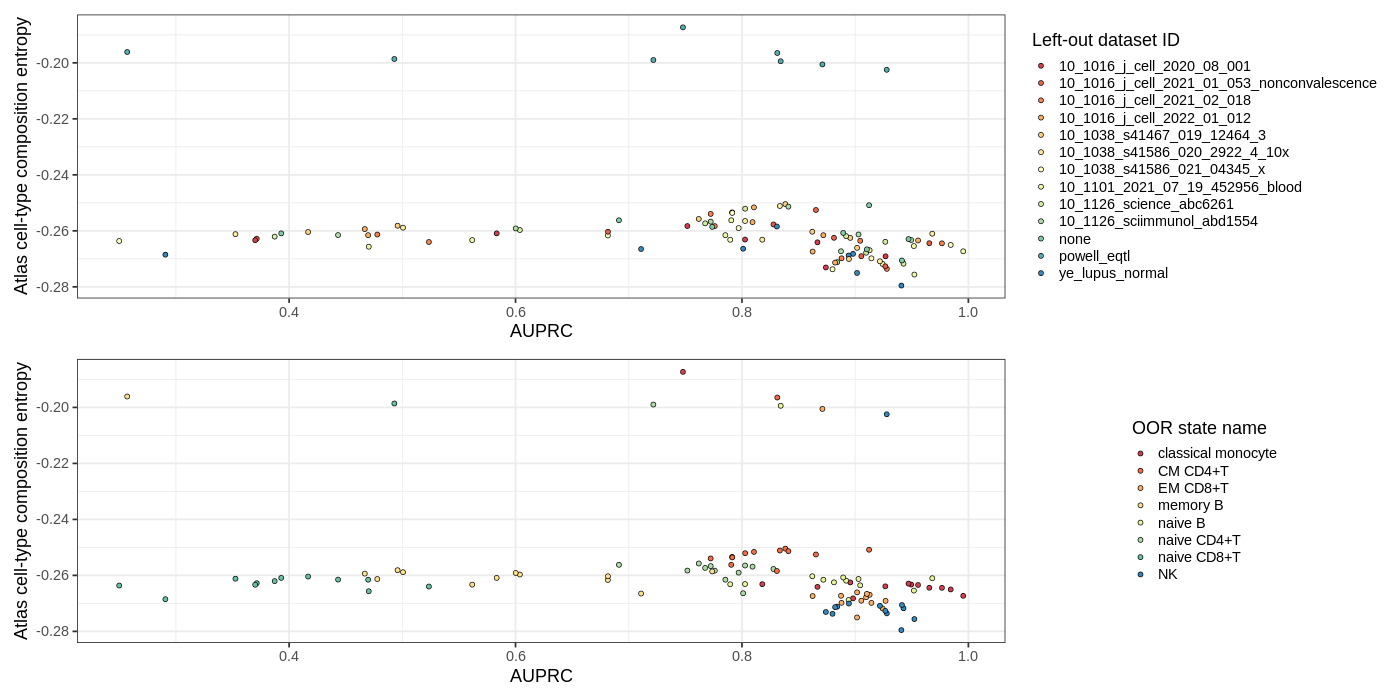

In [648]:
%%R -i auprc_df_min -w 1400 -h 700
library(RColorBrewer)
getPalette = colorRampPalette(brewer.pal(9, "Spectral"))

p1 <- auprc_df_min %>%
    ggplot(aes(AUPRC, adj_dataset_entropy, fill=remove_dataset))+
    # geom_line(aes(group=remove_dataset))+
    geom_point(shape=21, size=2) +
    theme_bw(base_size=18) +
    ylab('Atlas cell-type composition entropy') +
    scale_fill_manual(values = getPalette(13), name='Left-out dataset ID')

p2 <- auprc_df_min %>%
    ggplot(aes(AUPRC, adj_dataset_entropy, fill=OOR_state_name_pl))+
    # geom_line(aes(group=remove_dataset))+
    geom_point(shape=21, size=2) +
    theme_bw(base_size=18) +
    ylab('Atlas cell-type composition entropy') +
    scale_fill_brewer(palette='Spectral', name='OOR state name')
    
(p1 / p2) +
ggsave(paste0(figdir, 'rebuttal_figure_entropy.pdf'), width=12, height=15)


In [ ]:
%%R -i auprc_df_min -w 500 -h 500
auprc_df_min %>%
# filter(remove_dataset != 'powell_eqtl') %>%
group_by(OOR_state_name_pl) %>%
summarise(OOR_state_size=mean(OOR_state_size), 
          mean_entropy = mean(adj_dataset_entropy),
          sd_AUPRC = sd(AUPRC)) %>%
ggplot(aes(
#     log10(OOR_state_size), 
    mean_entropy,
    sd_AUPRC)) +
geom_point() +
ggpubr::stat_cor(color='black') +
scale_color_viridis_c()

In [269]:
n_cells = ct_size[ct_size['dataset_id'] != query_batch]
n_cells = n_cells.groupby('cell_type').sum()['n_cells']
n_cells = n_cells[n_cells > 0]
n_cells = n_cells[n_cells != n_cells.min()]


def get_entropy(n_cells):
    n_s = n_cells.sum()
    p_i_s = n_cells/n_s
    k = len(p_i_s)
    adj_entropy = (- sum(p_i_s * np.log2(p_i_s) ) / np.log2(k) ) - 1
    return(adj_entropy)

Text(0, 0.5, 'Normalized entropy')

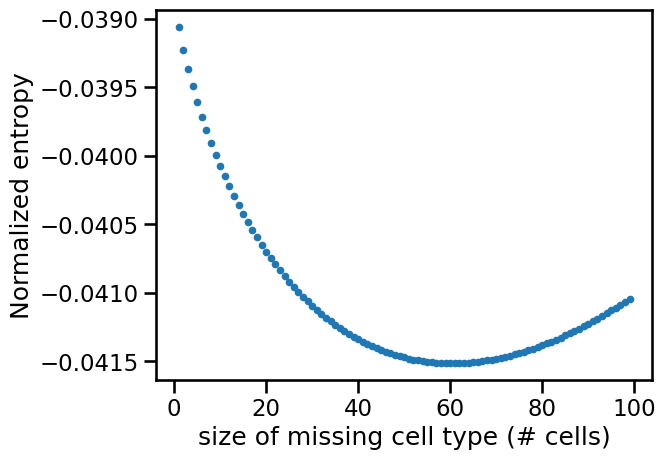

In [339]:
# n_cells = ct_size[ct_size['dataset_id'] != query_batch].groupby('cell_type').sum()['n_cells']
n_cells = pd.Series(np.arange(1,100))
entropies = []
for n in n_cells.sort_values():
    n_cells_test = n_cells[n_cells != n]
#     n_cells_test = n_cells.copy()
#     n_cells_test[n_cells_test == n] = 0
    entropies.append(get_entropy(n_cells_test))
plt.plot(n_cells.sort_values(), entropies, '.');
plt.xlabel("size of missing cell type (# cells)");
plt.ylabel("Normalized entropy")

# n_cells = pd.Series(np.arange(1,2100))
# entropies = []
# for n in n_cells.sort_values():
#     n_cells_test = n_cells[n_cells != n]
# #     n_cells_test = n_cells.copy()
# #     n_cells_test[n_cells_test == n] = 0
#     entropies.append(get_entropy(n_cells_test))
# plt.plot(n_cells.sort_values(), entropies, 'r.') 

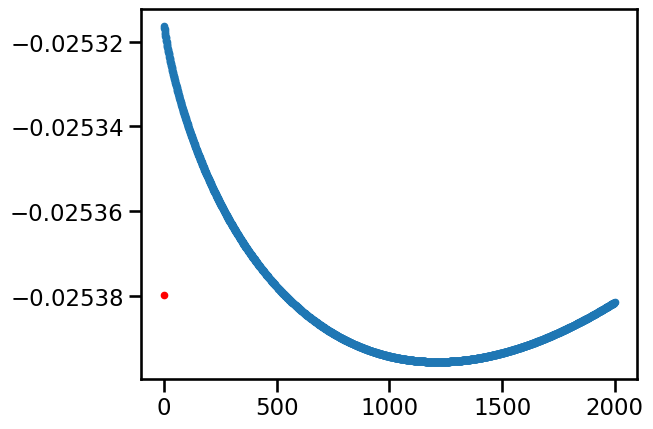

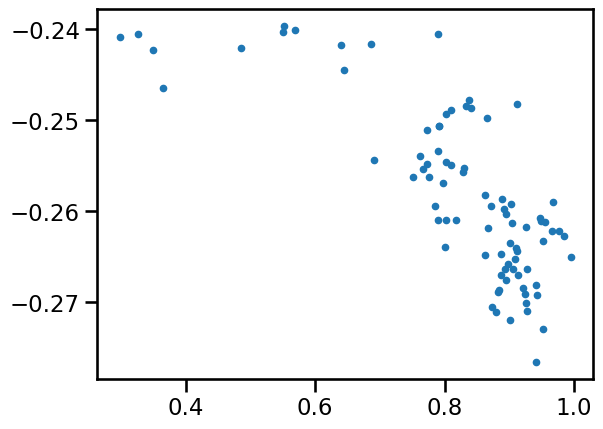

In [57]:
auprc_df_min = auprc_df_min[auprc_df_min['remove_dataset'] !='powell_eqtl']
plt.plot(auprc_df_min['AUPRC'], auprc_df_min['adj_dataset_entropy'], '.')

In [450]:
def get_dataset_composition(ct_size, remove_dataset, OOR_state_name):
    '''
    Compute normalized entropy of cell type distribution in dataset
    '''
    ct_size_dataset = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]
    n_cells = ct_size_dataset.groupby('cell_type')['n_cells'].sum()
    n_s = n_cells.sum()
    p_i_s = n_cells/n_s
#     k = len(p_i_s)
#     adj_entropy = (- sum(p_i_s * np.log2(p_i_s) ) / np.log2(k) ) - 1
    return(p_i_s)


In [490]:
colnames = [x['remove_dataset']+ "_" +x['OOR_state_name'] for _,x in auprc_df_min.iterrows()]
comp_df = pd.concat([get_dataset_composition(ct_size, x['remove_dataset'], x['OOR_state_name']) for _,x in auprc_df_min.iterrows()], 1)
comp_df = comp_df.fillna(0)
comp_df.columns = colnames

/tmp/ipykernel_6255/2864378026.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  comp_df = pd.concat([get_dataset_composition(ct_size, x['remove_dataset'], x['OOR_state_name']) for _,x in auprc_df_min.iterrows()], 1)


Text(0.5, 0, 'Correlation in cell type composition')

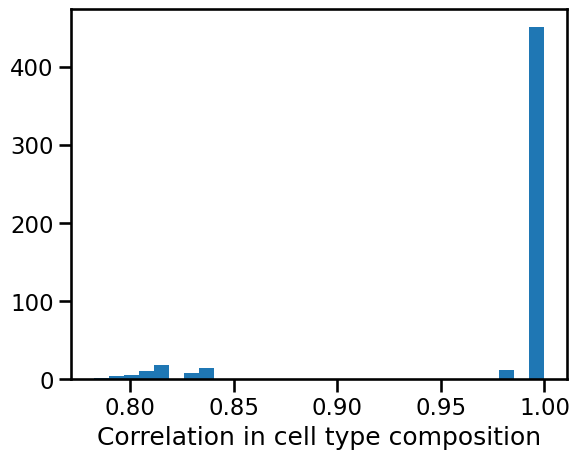

In [534]:
oor_states = auprc_df_min.OOR_state_name.unique()
cor_ls = []
for state in oor_states:
    cormat = comp_df.loc[:,comp_df.columns.str.endswith(state)].corr()
    upper_cormat = cormat.values[np.triu_indices_from(cormat.values, k=1)]
    cor_ls.append(upper_cormat.flatten())
#     plt.boxplot(upper_cormat.flatten());
#     plt.title(state);
#     plt.show()
plt.hist(np.hstack(cor_ls), bins=30);
plt.xlabel('Correlation in cell type composition')

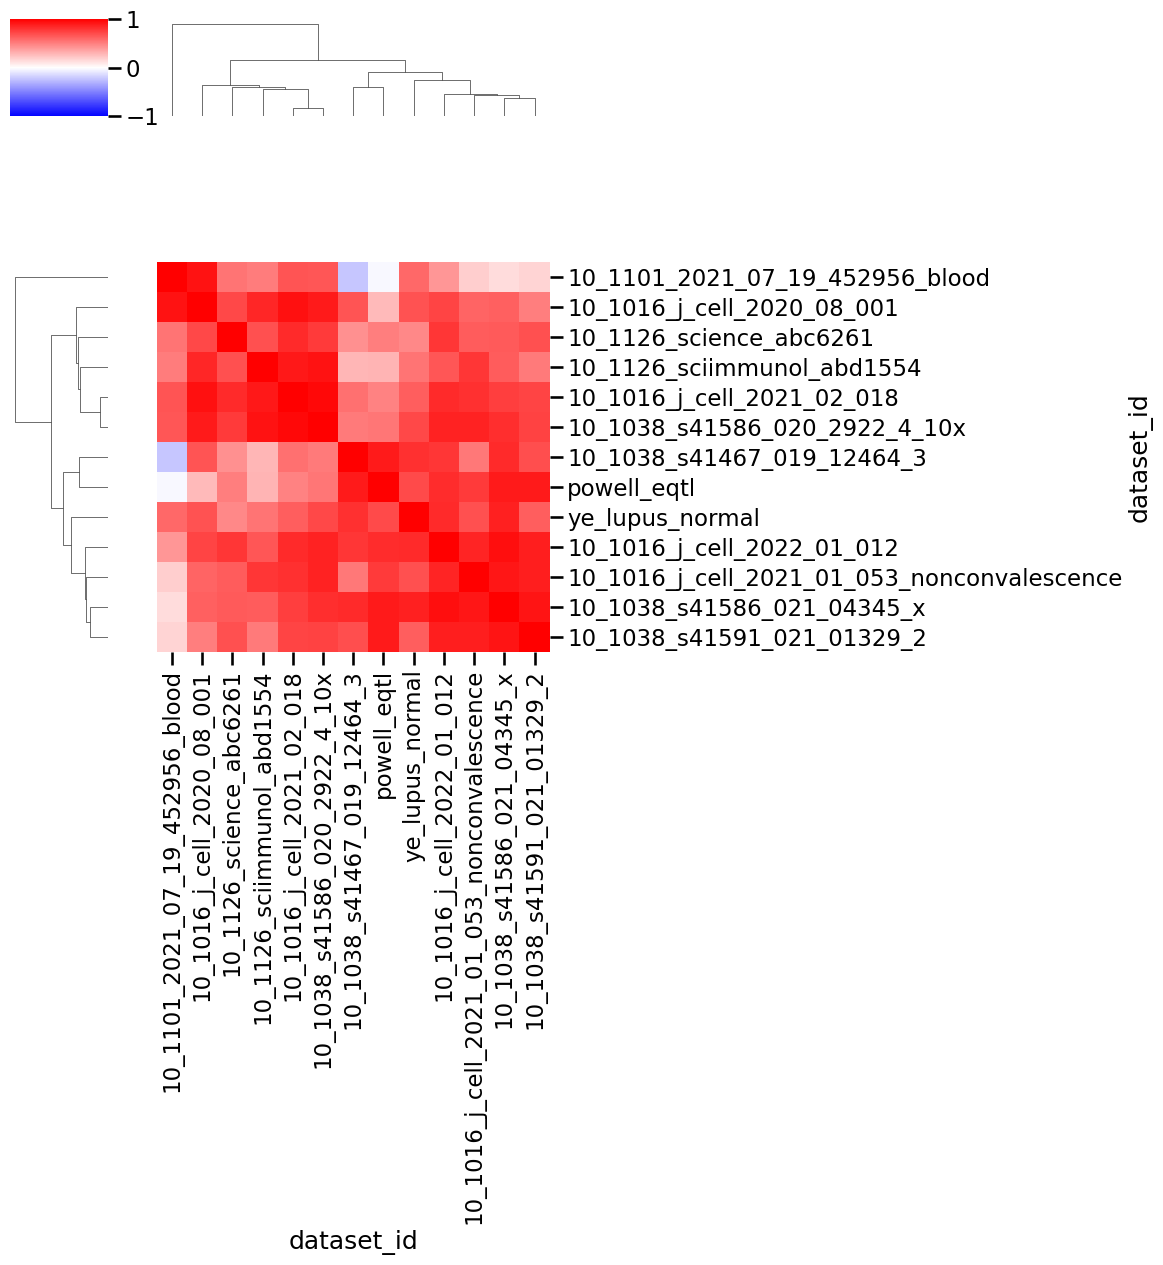

In [554]:
comp_mat = ct_size.pivot(index='dataset_id', values='n_cells', columns='cell_type').T
comp_mat = comp_mat/comp_mat.sum()
# plt.rcParams['figure.figsize'] = [10,10]
sns.clustermap(comp_mat.corr(), cmap='bwr', vmax=1, vmin=-1, figsize=(12,13));
plt.tight_layout();
plt.savefig(figdir+'rebuttal_fig_comp_correlation.pdf')